# Reproduction of nipype's tutorial example on finger-foot-lips dataset using FSL FEAT 

The pipelines were adapted on a dataset downloadable [**here**](https://openneuro.org/datasets/ds000114/versions/1.0.1). 

To use the notebooks, create a docker container using the instructions in the file and use the parent repository of **"analytic_variability_fmri"** as a volume. The dataset should be downloaded in a repository named **"tutorial_data"** in the directory **"data"** inside this repository. 
Otherwise, if you want to use different paths, you need to update these paths on the notebooks. 

This notebooks corresponds to the multisubject analysis part. It requires that the preprocessing + l1 analysis was already ran and that the results are stored in the "**datasink_fsl/results**" inside the "**data/tutorial_data**" directory. 

In [2]:
# Set the path to matlab 
## NECESSARY TO USE SPM
from nipype.interfaces import spm
matlab_cmd = '/opt/spm12-r7771/run_spm12.sh /opt/matlabmcr-2010a/v713/ script'
spm.SPMCommand.set_mlab_paths(matlab_cmd=matlab_cmd, use_mcr=True)

In [3]:
#from nipype.interfaces.fsl import 
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.utility import IdentityInterface, Function
from nipype import Workflow, Node
from nipype.interfaces.fsl import (L2Model, Merge, FLAMEO, ContrastMgr, 
                                   SmoothEstimate, Cluster, ImageMaths, Info)
from nipype.interfaces.spm import Normalize12
from nipype.algorithms.misc import Gunzip
from nilearn import plotting
%matplotlib inline

from os.path import join as opj
import os
import json

In [8]:
# REPOSITORIES TO FIND & STORE FILES 
## exp_dir : where the results files will be stored and where the data files are stored
## working_dir : where the intermediate results files will be stored (inside exp_dir)
## output_dir : where the final results files (the one you connect to datasink) will be stored inside exp_dir
exp_dir = '/home/analytic_variability_fmri/data/NARPS'
working_dir = 'workingdir_fsl'
output_dir = 'datasink_fsl'

In [9]:
# BASIC VARIABLES
contrast_list = ['1']

mask_file = "/home/analytic_variability_fmri/data/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz"

In [10]:
# Infosource
infosource = Node(IdentityInterface(fields=['contrast_id']),
                  name="infosource")

infosource.iterables = [('contrast_id', contrast_list)]

# SelectFiles 
copes_file = opj(output_dir, 'results', 'estimate', '_subject_id_*', "cope{contrast_id}.nii.gz")
varcopes_file = opj(output_dir, 'results', 'estimate', '_subject_id_*', "varcope{contrast_id}.nii.gz")
dof_file = opj(output_dir, 'results', 'estimate', '_subject_id_*', 'dof')

templates = {'varcopes' : varcopes_file, 'copes' : copes_file, 'dof' : dof_file}

selectfiles = Node(SelectFiles(templates, base_directory=exp_dir),
                   name="selectfiles")

In [11]:
# Datasink node : to save important files 
datasink = Node(DataSink(base_directory = exp_dir, container = output_dir), name = 'datasink')

In [12]:
def get_length(x):
    return len(x)

#fslmaths merged.nii.gz -abs -Tmin -bin mean_mask.nii.gz

def get_dofvolumes(dof_files, cope_files):
    import os
    import nibabel as nb
    import numpy as np
    img = nb.load(cope_files[0])
    if len(img.shape) > 3:
        out_data = np.zeros(img.shape)
    else:
        out_data = np.zeros(list(img.shape) + [1])
    for i in range(out_data.shape[-1]):
        dof = np.loadtxt(dof_files[i])
        out_data[:, :, :, i] = dof
    filename = os.path.join(os.getcwd(), 'dof_file.nii.gz')
    newimg = nb.Nifti1Image(out_data, None, img.header)
    newimg.to_filename(filename)
    return filename

def make_list(x):
    return [x]

In [14]:
specify_model = Node(L2Model(num_copes = 10), name='l2model')

generate_dof = Node(Function(input_names=['dof_files', 'cope_files'], output_names=['dof_volume'], 
                       function=get_dofvolumes), name='generate_dof')

### create analysis specific mask
#-Tmin: min across time
# -abs: absolute value
#-bin: use (current image>0) to binarise
merge_mask = Node(ImageMaths(op_string = '-abs -Tmin -bin'), name='merge_mask')

merge_copes = Node(Merge(dimension='t'), name='merge_copes')

merge_varcopes = Node(Merge(dimension='t'), name='merge_varcopes')

flame = Node(FLAMEO(run_mode = 'fe'), name='flameo')

smooth_estimate = Node(SmoothEstimate(), name='smooth_estimate') 

cluster = Node(Cluster(threshold = 2.3 ), name='cluster')

ztopval = Node(ImageMaths(op_string='-ztop', suffix='_pval'), name='z2pval')

In [15]:
l2_analysis = Workflow(base_dir = opj(exp_dir, working_dir), name = 'l2_analysis')

l2_analysis.connect([(infosource, selectfiles, [('contrast_id', 'contrast_id')]),
                    (selectfiles, merge_copes, [('copes', 'in_files')]),
                    (selectfiles, merge_varcopes, [('varcopes', 'in_files')]),
                    (selectfiles, generate_dof, [('dof', 'dof_files')]),
                    (merge_copes, generate_dof, [(('merged_file', make_list), 'cope_files')]),
                    (merge_copes, flame, [('merged_file', 'cope_file')]),
                    (merge_varcopes, flame, [('merged_file', 'var_cope_file')]),
                    (specify_model, flame, [('design_mat', 'design_file'),
                                           ('design_con', 't_con_file'),
                                           ('design_grp', 'cov_split_file')]),
                    (merge_copes, merge_mask, [('merged_file', 'in_file')]),
                    (merge_mask, flame, [('out_file', 'mask_file')]),
                    (generate_dof, flame, [('dof_volume', 'dof_var_cope_file')]),
                    (flame, smooth_estimate, [('zstats', 'zstat_file')]), 
                    (flame, cluster, [('zstats', 'in_file')]),
                    (smooth_estimate, cluster, [('dlh', 'dlh'),
                                         ('volume', 'volume')]), 
                    (flame, ztopval, [('zstats', 'in_file')]),
                    (flame, datasink, [('zstats', 'stats')]),
                    (cluster, datasink, [('threshold_file', 'stats.@thresh'),
                                        ('index_file', 'stats.@index'),
                                        ('localmax_txt_file', 'stats.@localmax')])])

210309-13:44:46,283 nipype.workflow INFO:
	 Generated workflow graph: /home/analytic_variability_fmri/data/NARPS/workingdir_fsl/l2_analysis/graph.png (graph2use=flat, simple_form=True).


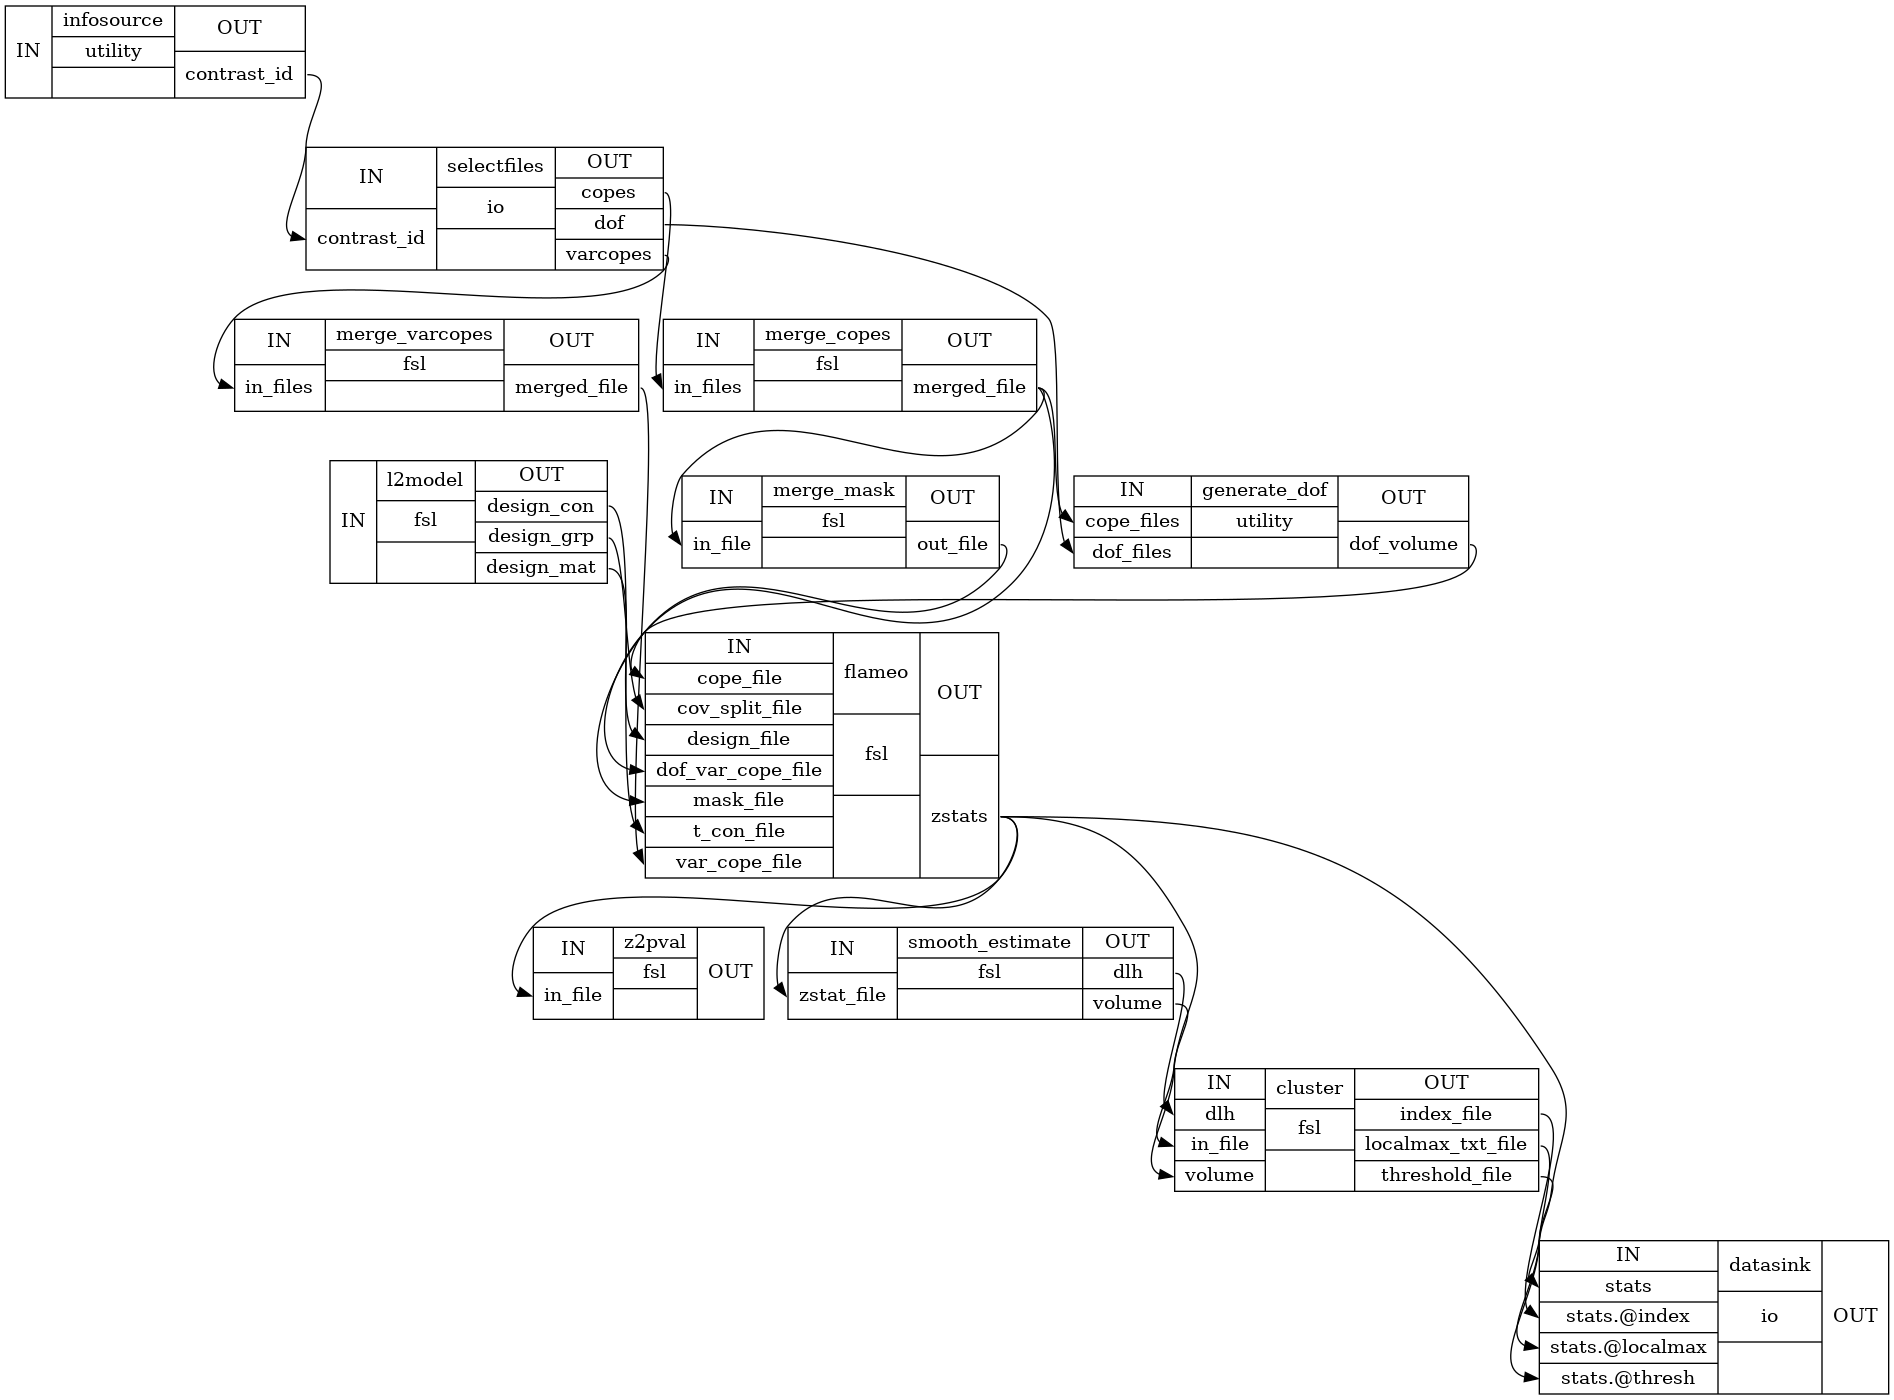

In [19]:
# Create analysis output graph
l2_analysis.write_graph(graph2use='flat', format='png')

# Visualize the graph
from IPython.display import Image
Image(filename=opj(l2_analysis.base_dir, 'l2_analysis', 'graph_detailed.png'))

In [89]:
l2_analysis.run()

210303-13:11:38,779 nipype.workflow INFO:
	 Workflow l2_analysis settings: ['check', 'execution', 'logging', 'monitoring']
210303-13:11:38,795 nipype.workflow INFO:
	 Running serially.
210303-13:11:38,796 nipype.workflow INFO:
	 [Node] Setting-up "l2_analysis.selectfiles" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/l2_analysis/_contrast_id_1/selectfiles".
210303-13:11:38,800 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
210303-13:11:38,804 nipype.workflow INFO:
	 [Node] Finished "l2_analysis.selectfiles".
210303-13:11:38,805 nipype.workflow INFO:
	 [Node] Setting-up "l2_analysis.merge_varcopes" in "/home/analytic_variability_fmri/data/tutorial_data/workingdir_fsl/l2_analysis/_contrast_id_1/merge_varcopes".
210303-13:11:38,809 nipype.workflow INFO:
	 [Node] Cached "l2_analysis.merge_varcopes" - collecting precomputed outputs
210303-13:11:38,810 nipype.workflow INFO:
	 [Node] "l2_analysis.merge_varcopes" found cached.


RuntimeError: Workflow did not execute cleanly. Check log for details